In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [172]:
hotel_bookings= pd.read_csv('/content/drive/MyDrive/Hotel/hotel_bookings.csv')
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [173]:
# ML Imports and configuration
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import set_config
set_config(display="diagram")

In [174]:
hotel_bookings['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

**Calculating the number of bookings by month**

In [175]:
#Define the corect months order
months= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#convert to categorical with months
hotel_bookings['arrival_date_month'] = pd.Categorical(
    hotel_bookings['arrival_date_month'],
    categories= months,
    ordered= True
    )

# Now group by month
booking_by_month = hotel_bookings.groupby(['arrival_date_month'])[['hotel']].count().rename(columns={'hotel':'nb_bookings'})

booking_by_month

,nb_bookings
arrival_date_month,
January,5929
February,8068
March,9794
April,11089
May,11791
June,10939
July,12661
August,13877
September,10508


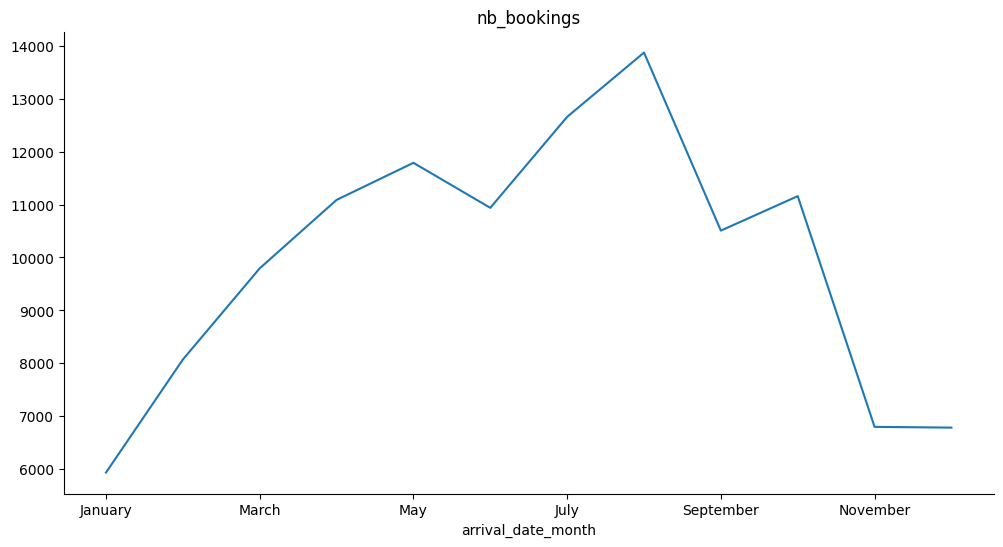

In [176]:
booking_by_month['nb_bookings'].plot(kind='line', figsize=(12,6), title='nb_bookings')
plt.gca().spines[['top', 'right']].set_visible(False)

In [177]:
booking_by_month_long= booking_by_month.reset_index().melt(
    id_vars= 'arrival_date_month',
    value_vars= 'nb_bookings',
    var_name= 'Month',
    value_name= 'Nbr of bookings'
)

booking_by_month_long

,arrival_date_month,Month,Nbr of bookings
0,January,nb_bookings,5929
1,February,nb_bookings,8068
2,March,nb_bookings,9794
3,April,nb_bookings,11089
4,May,nb_bookings,11791
5,June,nb_bookings,10939
6,July,nb_bookings,12661
7,August,nb_bookings,13877
8,September,nb_bookings,10508
9,October,nb_bookings,11160


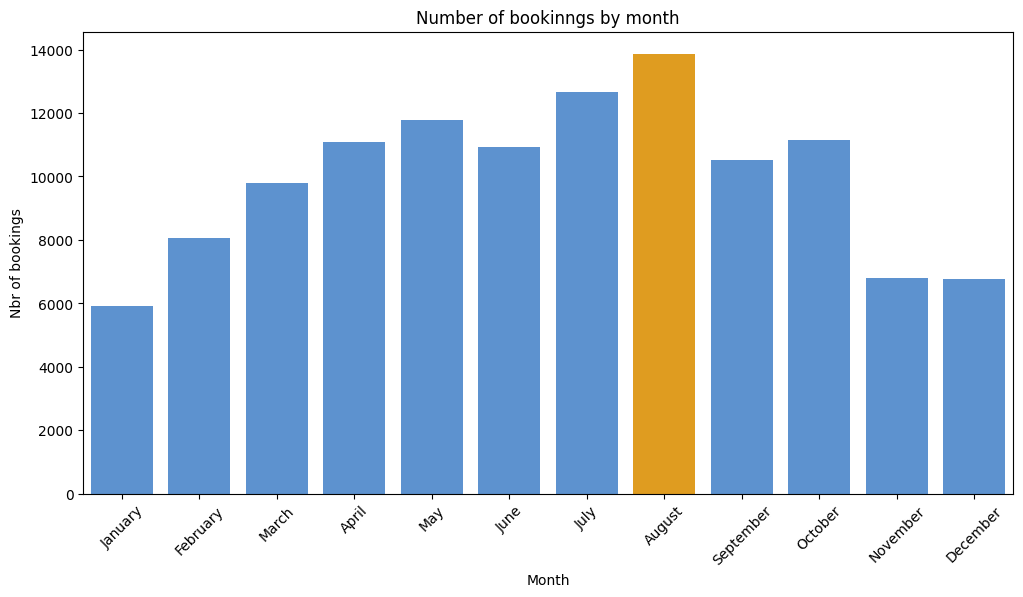

In [178]:
#plot by month
colors= ['#4A90E2' if v != booking_by_month_long['Nbr of bookings'].max() else 'orange' for v in booking_by_month_long['Nbr of bookings']]
plt.figure(figsize=(12,6))
sns.barplot(
    data=booking_by_month.reset_index(),
    x='arrival_date_month',
    y='nb_bookings',
    palette= colors
    )

#title and labels
plt.title('Number of bookinngs by month')
plt.xlabel('Month')
plt.ylabel('Nbr of bookings')
plt.xticks(rotation =45)

plt.show()

In [179]:
# Calculating the number of bookings by month/Hotel Type
booking_by_month_hotel_type = hotel_bookings.groupby(['arrival_date_month','hotel']).size().unstack().rename(columns={'City Hotel':'nb_bookings_city_hotel', 'Resort Hotel':'nb_bookings_resort_hotel'})
booking_by_month_hotel_type

hotel,nb_bookings_city_hotel,nb_bookings_resort_hotel
arrival_date_month,,
January,3736,2193
February,4965,3103
March,6458,3336
April,7480,3609
May,8232,3559
June,7894,3045
July,8088,4573
August,8983,4894
September,7400,3108


In [180]:
booking_long = booking_by_month_hotel_type.reset_index().melt(
    id_vars='arrival_date_month',
    value_vars=['nb_bookings_city_hotel', 'nb_bookings_resort_hotel'],
    var_name='Hotel Type',
    value_name='Nbr of Bookings'
)

booking_long

,arrival_date_month,Hotel Type,Nbr of Bookings
0,January,nb_bookings_city_hotel,3736
1,February,nb_bookings_city_hotel,4965
2,March,nb_bookings_city_hotel,6458
3,April,nb_bookings_city_hotel,7480
4,May,nb_bookings_city_hotel,8232
5,June,nb_bookings_city_hotel,7894
6,July,nb_bookings_city_hotel,8088
7,August,nb_bookings_city_hotel,8983
8,September,nb_bookings_city_hotel,7400
9,October,nb_bookings_city_hotel,7605


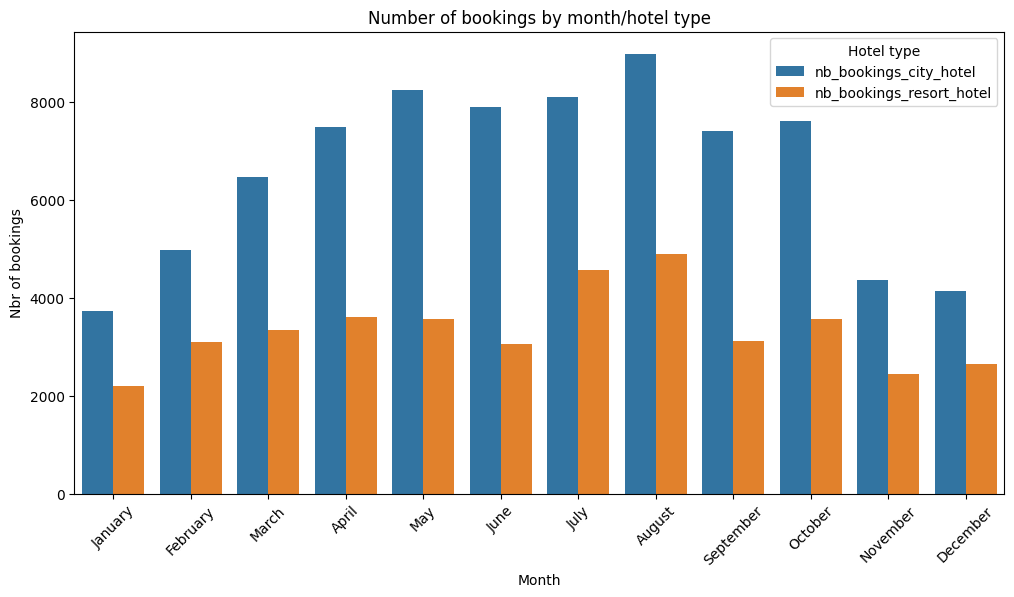

In [181]:
# Seaborn bar plot by month and hotel type
plt.figure(figsize=(12, 6))
sns.barplot(
    data=booking_long.reset_index(),
    x='arrival_date_month',
    y='Nbr of Bookings',
    hue='Hotel Type'
)

# Titles and labels
plt.title('Number of bookings by month/hotel type')
plt.xlabel('Month')
plt.ylabel('Nbr of bookings')
plt.xticks(rotation=45)
plt.legend(title='Hotel type')

plt.show()

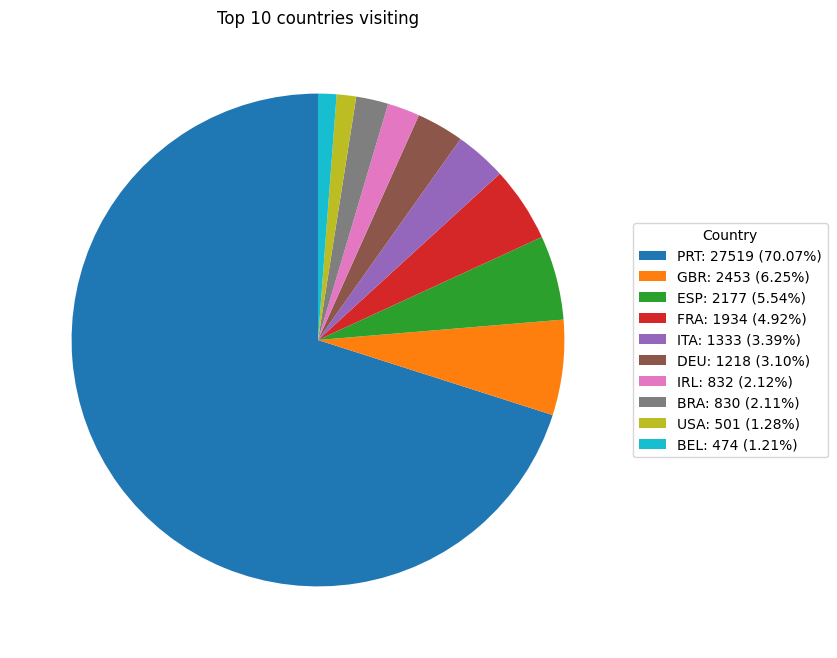

In [182]:
#Select the top 10 countries visiting
top_10_countries = hotel_bookings[hotel_bookings['is_canceled']==1]['country'].value_counts().head(10)
top_10_countries.plot(
    kind='pie',
    figsize=(10, 8),
    labels=None,
    startangle=90
)

plt.title('Top 10 countries visiting')
plt.ylabel("")
plt.legend(
    [f"{c}: {v} ({v/sum(top_10_countries)*100:.2f}%)" for c,v in top_10_countries.items()],
    title="Country",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.show()

# **Confirmed bookings by Month (non-canceled reservations).**


## **By Month**

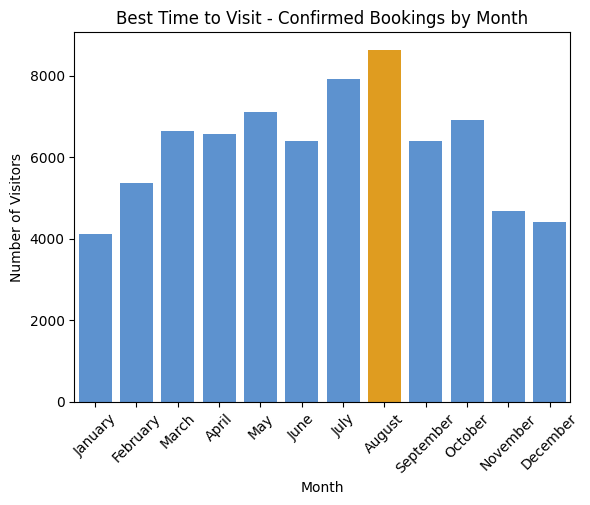

In [183]:
#Filter only the confirmed bookings
confirmed_bookings = hotel_bookings[hotel_bookings['is_canceled']== 0]

# counts booking by arrival month
best_months = confirmed_bookings['arrival_date_month'].value_counts().sort_index()

colors= ['#4A90E2' if v != best_months.max() else 'orange' for v in best_months.values]


# Seaborn barplot
sns.barplot(
    x=best_months.index,
    y=best_months.values,
    palette=colors
)

# Titles and labels
plt.title('Best Time to Visit - Confirmed Bookings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.show()

## **By Season**

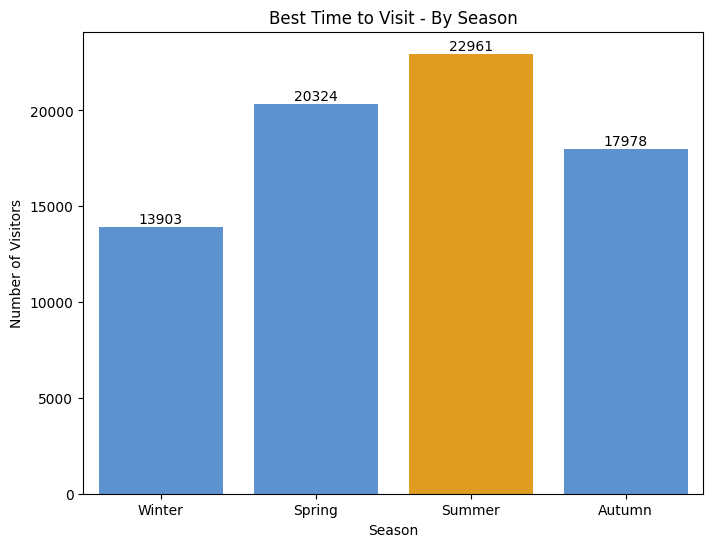

In [184]:
# by season
month_to_season= {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn'
}

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

confirmed_bookings['season'] = confirmed_bookings['arrival_date_month'].map(month_to_season)

#count per season
season_counts= confirmed_bookings['season'].value_counts().reindex(season_order)

# Prepare DataFrame for seaborn
season_df = season_counts.reset_index()
season_df.columns = ['season', 'count']

# Highlight highest bar
custom_blue = '#4A90E2'
highlight_color = 'orange'
colors = [highlight_color if v == season_df['count'].max() else custom_blue for v in season_df['count']]

# Plot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=season_df, x='season', y='count', palette=colors)

plt.title('Best Time to Visit - By Season')
plt.xlabel('Season')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=0)

# Add labels
for i, row in season_df.iterrows():
    ax.text(i, row['count'] + 200, f"{row['count']:.0f}", ha='center')

plt.show()

# **Non Confirmed bookings by Month (Canceled reservations).**

In [185]:
# Filter canceled bookings
canceled_bookings = hotel_bookings[hotel_bookings['is_canceled'] == 1]

## **By Month**

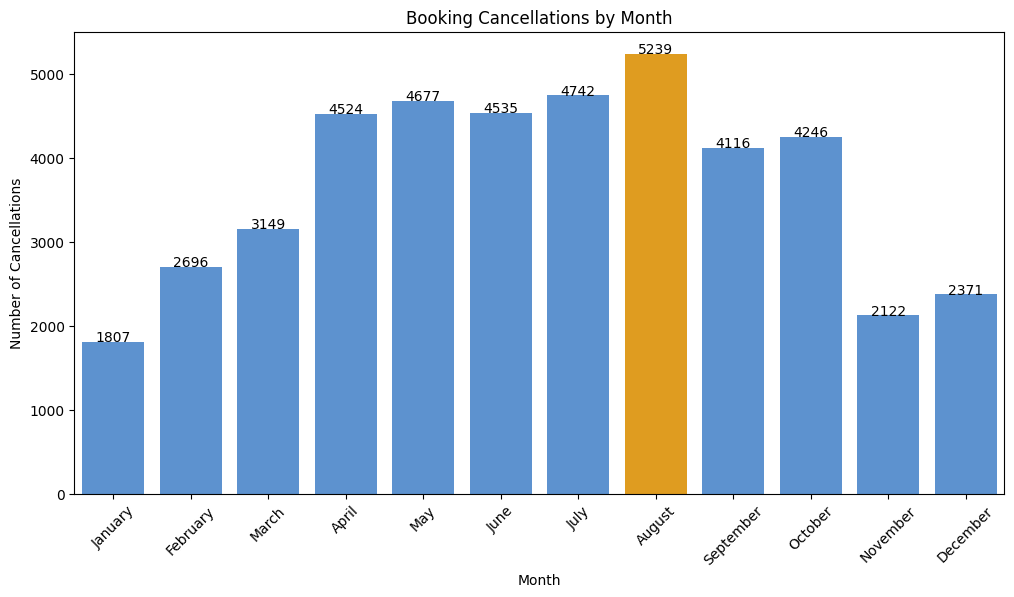

In [186]:
# Count cancellations per month
cancellations_by_month = canceled_bookings['arrival_date_month'].value_counts()

# Ensure months are in calendar order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
cancellations_by_month = cancellations_by_month.reindex(month_order)

# Convert to DataFrame
cancellations_df = cancellations_by_month.reset_index()
cancellations_df.columns = ['Month', 'Cancellations']

# Highlight the peak month
colors = ['orange' if x == cancellations_df['Cancellations'].max() else '#4A90E2'
          for x in cancellations_df['Cancellations']]

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Month', y='Cancellations', data=cancellations_df, palette=colors)

# Add labels on top of each bar
for i, row in cancellations_df.iterrows():
    ax.text(i, row['Cancellations'] + 5, f"{row['Cancellations']}", ha='center')

plt.title('Booking Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45)
plt.show()

## **By Season**

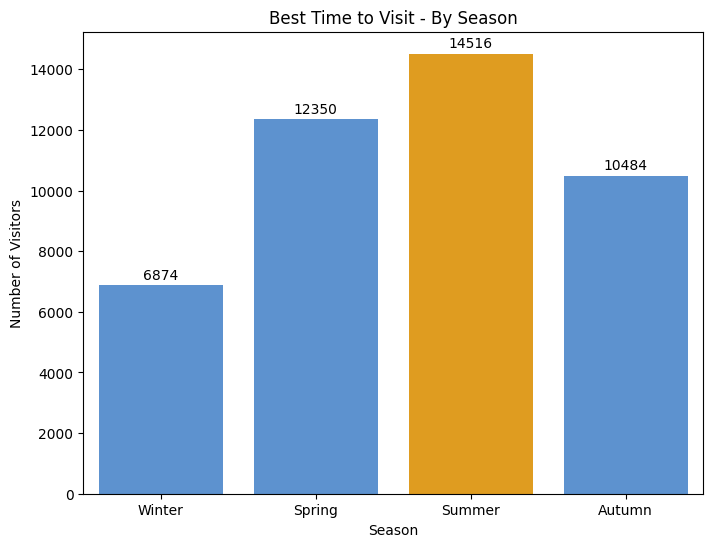

In [187]:
# by season
month_to_season= {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Autumn', 'October': 'Autumn', 'November': 'Autumn'
}

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# map months to the season
canceled_bookings['season'] = canceled_bookings['arrival_date_month'].map(month_to_season)

#count cancelation by season
season_cancel_counts= canceled_bookings['season'].value_counts().reindex(season_order)

# Prepare DataFrame for seaborn
season_cancel_df = season_cancel_counts.reset_index()
season_cancel_df.columns = ['season', 'count']

# Highlight highest bar
custom_blue = '#4A90E2'
highlight_color = 'orange'
colors = [highlight_color if v == season_cancel_df['count'].max() else custom_blue for v in season_cancel_df['count']]

# Plot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=season_cancel_df, x='season', y='count', palette=colors)

plt.title('Best Time to Visit - By Season')
plt.xlabel('Season')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=0)

# Add labels
for i, row in season_cancel_df.iterrows():
    ax.text(i, row['count'] + 200, f"{row['count']:.0f}", ha='center')

plt.show()

# **ADR Insights**

In [188]:
confirmed_bookings.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'season'],
      dtype='object')

In [189]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

## **By Month**

In [190]:
avg_adr_by_month= confirmed_bookings.groupby('arrival_date_month')['adr'].mean().reindex(month_order)
avg_adr_by_month

,adr
arrival_date_month,
January,67.001050
February,72.419429
March,77.331574
April,97.877849
May,104.842342
June,114.589636
July,129.253758
August,142.088795
September,107.277159


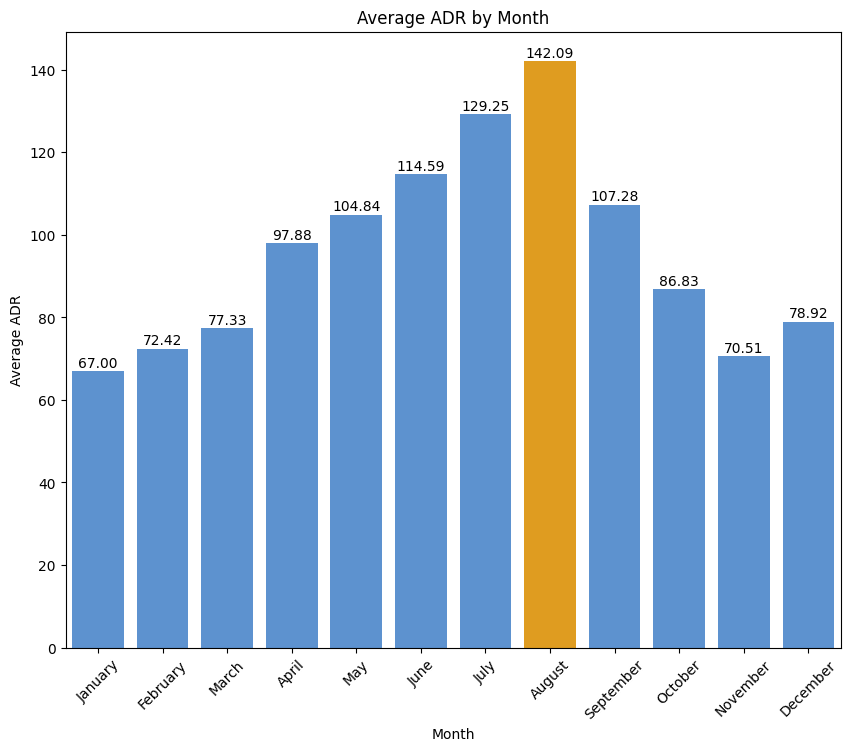

In [191]:
# Convert Series to DataFrame for Seaborn
avg_adr_month_df = avg_adr_by_month.reset_index()
avg_adr_month_df.columns = ['arrival_date_month', 'adr']

# Define colors: highlight the max ADR
colors = ['orange' if x == avg_adr_month_df['adr'].max() else '#4A90E2' for x in avg_adr_month_df['adr']]

# Plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='arrival_date_month', y='adr', data=avg_adr_month_df, palette=colors)

plt.title('Average ADR by Month')
plt.xlabel('Month')
plt.ylabel('Average ADR')
plt.xticks(rotation=45)

# Add value labels
for i, row in avg_adr_month_df.iterrows():
    ax.text(i, row['adr'] + 1, f"{row['adr']:.2f}", ha='center')

plt.show()

## **By Season**

In [192]:
avg_adr_by_season= confirmed_bookings.groupby('season')['adr'].mean().reindex(season_order)
avg_adr_by_season

,adr
season,
Winter,72.874547
Spring,93.597954
Summer,129.992402
Autumn,89.857589


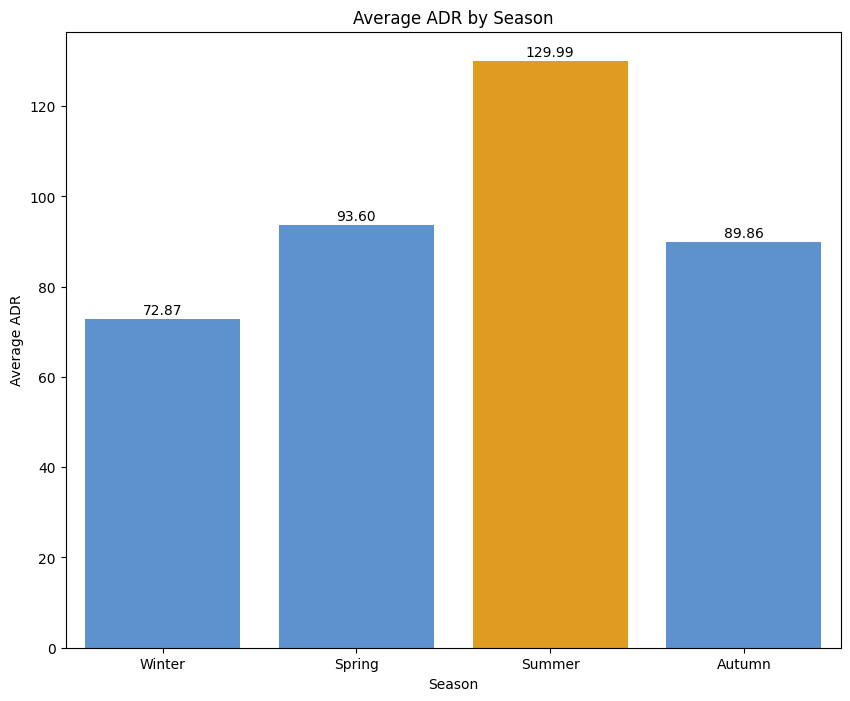

In [193]:
# Convert Series to DataFrame for Seaborn
avg_adr_season_df = avg_adr_by_season.reset_index()
avg_adr_season_df.columns = ['season', 'adr']

# Define colors: highlight the max ADR
colors = ['orange' if x == avg_adr_season_df['adr'].max() else '#4A90E2' for x in avg_adr_season_df['adr']]

# Plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='season', y='adr', data=avg_adr_season_df, palette=colors)

plt.title('Average ADR by Season')
plt.xlabel('Season')
plt.ylabel('Average ADR')
plt.xticks(rotation=0)

# Add value labels
for i, row in avg_adr_season_df.iterrows():
    ax.text(i, row['adr'] + 1, f"{row['adr']:.2f}", ha='center')

plt.show()

## **By Hotel Type**

In [194]:
avg_adr_by_hotel= confirmed_bookings.groupby('hotel')['adr'].mean()
avg_adr_by_hotel

,adr
hotel,
City Hotel,105.745948
Resort Hotel,90.788971


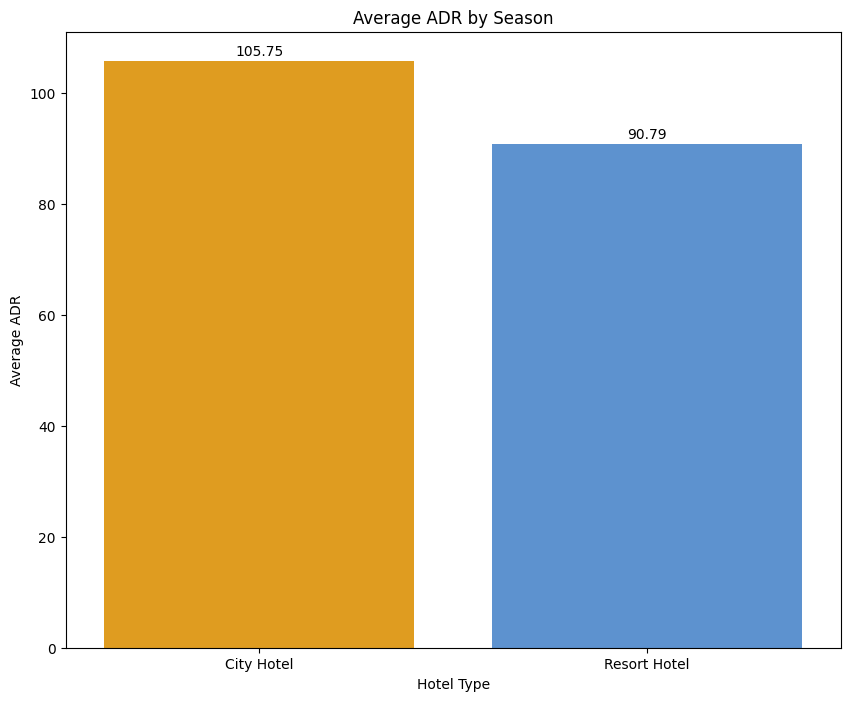

In [195]:
# Convert Series to DataFrame for Seaborn
avg_adr_hotel_df = avg_adr_by_hotel.reset_index()
avg_adr_hotel_df.columns = ['hotel', 'adr']

# Define colors: highlight the max ADR
colors = ['orange' if x == avg_adr_hotel_df['adr'].max() else '#4A90E2' for x in avg_adr_hotel_df['adr']]

# Plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='hotel', y='adr', data=avg_adr_hotel_df, palette=colors)

plt.title('Average ADR by Season')
plt.xlabel('Hotel Type')
plt.ylabel('Average ADR')
plt.xticks(rotation=0)

# Add value labels
for i, row in avg_adr_hotel_df.iterrows():
    ax.text(i, row['adr'] + 1, f"{row['adr']:.2f}", ha='center')

plt.show()

# **Training Model**

### **1- Spliging the data into training and test sets**

In [196]:
hotel_bookings.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [197]:
hotel_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   hotel                           119390 non-null  object  
 1   is_canceled                     119390 non-null  int64   
 2   lead_time                       119390 non-null  int64   
 3   arrival_date_year               119390 non-null  int64   
 4   arrival_date_month              119390 non-null  category
 5   arrival_date_week_number        119390 non-null  int64   
 6   arrival_date_day_of_month       119390 non-null  int64   
 7   stays_in_weekend_nights         119390 non-null  int64   
 8   stays_in_week_nights            119390 non-null  int64   
 9   adults                          119390 non-null  int64   
 10  children                        119386 non-null  float64 
 11  babies                          119390 non-null  int64   
 12  me

In [198]:
# list all numerical features
numerical_features = [
    'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
    'stays_in_week_nights', 'stays_in_weekend_nights',
    'adults', 'children', 'babies',
    'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes',
    'days_in_waiting_list', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests'
]

# list all categorical features
categorical_feature =[
    'hotel', 'arrival_date_month', 'meal',
    'market_segment', 'distribution_channel', 'reserved_room_type',
    'assigned_room_type', 'deposit_type', 'customer_type'
]


# Split data into features and target
features= numerical_features + categorical_feature

X= hotel_bookings[features]
y= hotel_bookings['is_canceled']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size= 0.3, random_state= 42)

### **2 - Preprocessing the Data**

In [199]:
#Numeric feature
numeric_transformer = SimpleImputer(strategy = 'constant')

# Categorical features: one hot-encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value= 'Unknown')),
    ('onehot', OneHotEncoder(handle_unknown= 'ignore'))
])

#combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_feature)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['lead_time', 'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_week_nights',
                                  'stays_in_weekend_nights', 'adults',
                                  'children', 'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waiting_list',
                                  'adr', 'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'assigned_room_type',
                                  'deposit_type', 'customer_type'])])

### **3 - Build ML Pipeline**

In [200]:
clf= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators= 100, random_state= 1234))
])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_week_nights',
                                                   'stays_in_weekend_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'd...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier', RandomForestClassifier(random_state=1234))])

In [164]:
#Train the model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_week_nights',
                                                   'stays_in_weekend_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'd...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier', RandomForestClassifier(random_state=1234))])

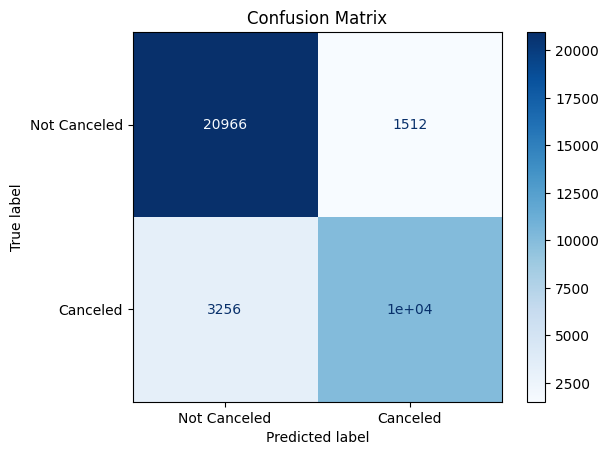

In [165]:
#Evaluate the model
y_pred= clf.predict(X_test)


# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Not Canceled', 'Canceled'])
disp.plot(cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [166]:
#Accuracy
print('Accuracy=', accuracy_score(y_test, y_pred))

print('')

print(cm)

print('')

#Classification Report
print(classification_report(y_test, y_pred))

Accuracy= 0.8668788564089678

[[20966  1512]
 [ 3256 10083]]

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     22478
           1       0.87      0.76      0.81     13339

    accuracy                           0.87     35817
   macro avg       0.87      0.84      0.85     35817
weighted avg       0.87      0.87      0.86     35817



In [167]:
TN, FP, FN, TP = cm.ravel()
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
print('True Positives:', TP)

True Negatives: 20966
False Positives: 1512
False Negatives: 3256
True Positives: 10083


# **Feature Importance**

## **Get Feature Names After Processing**

In [168]:
# After fitting the preprocessor
preprocessor.fit(X_train)

# Numeric feature remain the same
num_features = numerical_features

# Categorical features get expanded after one-hot encoding
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_feature)

# Combine all features
all_features = np.concatenate([num_features, cat_features])

all_features

array(['lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_week_nights',
       'stays_in_weekend_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'arrival_date_month_April',
       'arrival_date_month_August', 'arrival_date_month_December',
       'arrival_date_month_February', 'arrival_date_month_January',
       'arrival_date_month_July', 'arrival_date_month_June',
       'arrival_date_month_March', 'arrival_date_month_May',
       'arrival_date_month_November', 'arrival_date_month_October',
       'arrival_date_month_September', 'meal_BB', 'meal_FB', 'meal_HB',
       'meal_SC', 'meal_Undefined', 'market_segment_Aviation',
       'market_segment_Complementary', 'market_segment_Corporate',
   

## **Get Feature Importance**

In [169]:
# using clf 'my trained Random Forest'
importances = clf.named_steps['classifier'].feature_importances_

# create a DataFrame for easy  viewing
feature_importances = pd.DataFrame({
    'feature': all_features,
    'importance': importances
    })

# sort them by importance
feature_importances = feature_importances.sort_values(by='importance', ascending= False)
feature_importances.head(10)

,feature,importance
0,lead_time,0.142322
13,adr,0.098192
70,deposit_type_Non Refund,0.083645
69,deposit_type_No Deposit,0.079190
2,arrival_date_day_of_month,0.071852
1,arrival_date_week_number,0.056772
15,total_of_special_requests,0.056465
3,stays_in_week_nights,0.045935
9,previous_cancellations,0.037049
4,stays_in_weekend_nights,0.029250


## **Plot the top features**

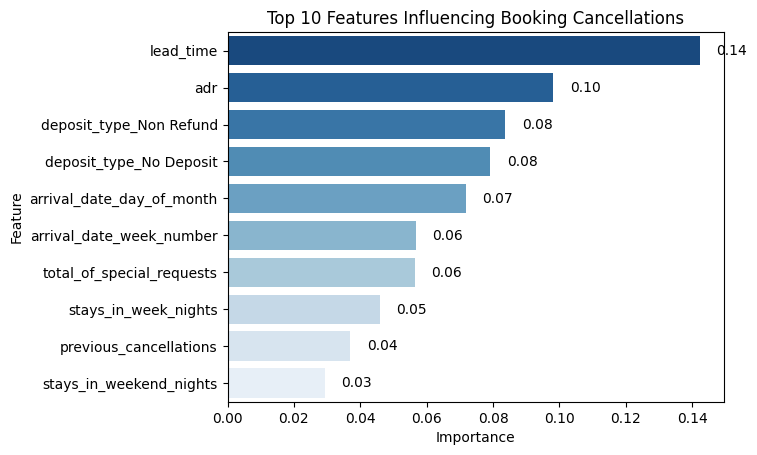

In [170]:
top_n = 10
top_features = feature_importances.head(top_n)

# Seaborn horizontal bar plot
sns.barplot(
    x='importance',
    y='feature',
    data=top_features,
    palette='Blues_r'  # reversed blue palette
)

# Axis labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Influencing Booking Cancellations')

# Add value labels
for i, v in enumerate(top_features['importance']):
    plt.text(v + 0.005, i, f'{v:.2f}', va='center')

plt.show()